# Баланс диференційних спектрів - Тестування
Цей записник використовується для перевірки методу навчання використовуючи моделі різних видів та даних. Хто знає, що ми знайдемо тут!

Тести повинні бути візуалізовані на фоні оригінального тренду або інших моделей, а також повинні бути обчислені наступні параметри:
- медіана
- дисперсія
- стандартне відхилення
- лінійне відхилення
- коваріація
- конкордація

Якщо потрібно буде додати якийсь мотлох тут то, будь ласка, тримай більшість інфраструктурного коду та іншого непотребства в інших файлах там, де ми не будемо це бачити, а сюди просто імпортуй необхідні функції та класи... Не знаю навіщо писати таке нагадування самому собі, але хто знає.

_Gloria in excelsis Stella Caesa!_

In [14]:
# Main imports
import pandas as pd
import numpy as np

from modules.extra import poly_fit, dsb_fit
from modules.utils import multi_plot, statistics, timed
from modules.models import apply_noise

## Експоненційна модель
Так, це наша стара знайома, тому використаємо її с початку для тестування. Оскільки це ідеальна модель, то вона визначена в своєму файлі і повинна бути імпортована.

Загальні параметри моделі:
- форма: $0.0000005 * x^2$
- розмір: 10000
- аномалії: 3

[poly] took 13.87080ms to complete.
[dsb] took 210.76520ms to complete.
[dsb_num] took 508.38700ms to complete.


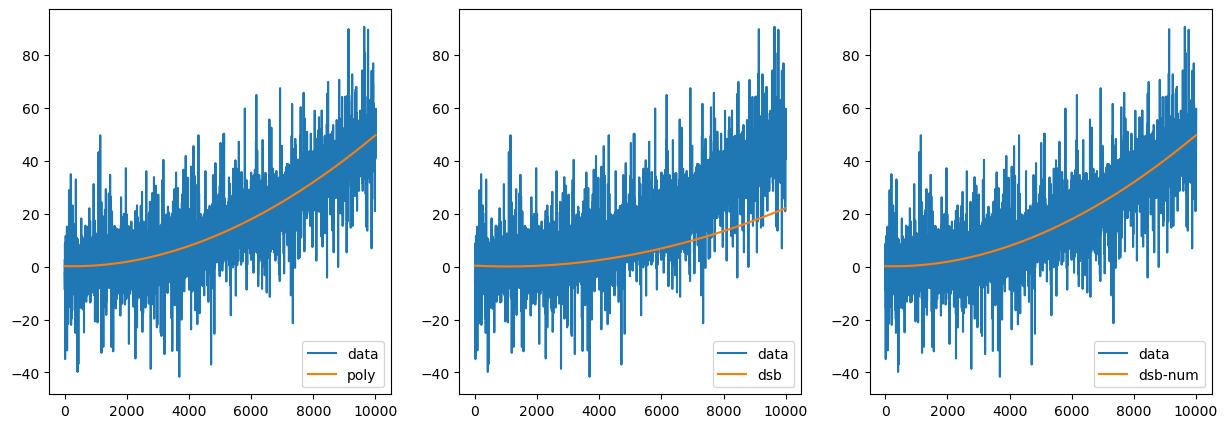

            median    variance  std. div.      lin. div.  covariance  concordance
poly     12.385188  222.313023  14.910165   48028.041640  222.313023     0.903210
dsb       4.425157   43.942573   6.628919  114784.175573   98.666188     0.508886
dsb-num  12.386505  222.315572  14.910251   48028.420629  222.314169     0.903213
data     13.045265  269.524352  16.417197       0.000000  269.524352     1.000000


In [15]:
# Model import
from modules.models import exponential1

# Create
ideal = exponential1()
model = apply_noise(ideal)

# Fitting
fitted_poly = timed(lambda: poly_fit(model, 4), label="poly")
fitted_dsb = timed(
    lambda: dsb_fit("a0 + a1*t + a2*exp(a3*t)", "t", model, numeric=False), label="dsb"
)
fitted_dsb_numeric = timed(
    lambda: dsb_fit("a0 + a1*t + a2*exp(a3*t)", "t", model), label="dsb_num"
)

# Display
results = (fitted_poly, "poly"), (fitted_dsb, "dsb"), (fitted_dsb_numeric, "dsb-num")
multi_plot(model, *results)
statistics(ideal, *results)

## Реальні дані: USD обмін
Цей набір даних достатньо малий, але цього достатньо щоб протестувати нелінійні штуки, оскільки для попередньої моделі поліноміальна модель була достатньою.
- форма: ???
- розмір: 161

[poly] took 14.32730ms to complete.
[dsb] took 269.90800ms to complete.
[dsb_num] took 340.74760ms to complete.


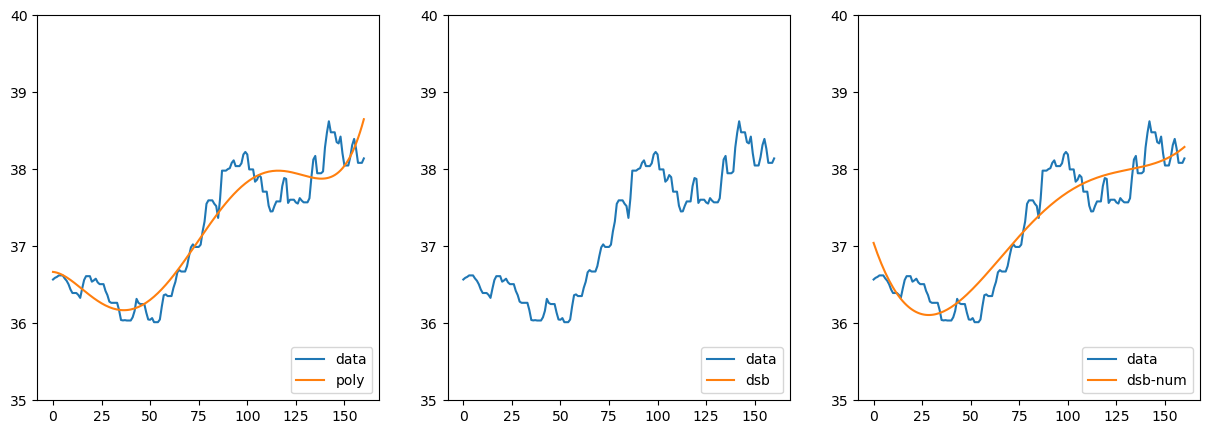

            median   variance  std. div.    lin. div.  covariance  concordance
poly     37.260237   0.561493   0.749328    34.292776    0.561493     0.912883
dsb      73.325919  24.555325   4.955333  5334.424885   -2.821073    -0.004300
dsb-num  37.267705   0.547425   0.739882    39.679175    0.547427     0.902395
data     37.452100   0.631848   0.794889     0.000000    0.631848     1.000000


In [16]:
# Read data
raw_data = pd.read_excel("data/usd_2023-2024_1.xlsx", "USD")
usd_data = np.array(raw_data.iloc[0:161, 6].values)

# Fitting
fitted_poly = timed(lambda: poly_fit(usd_data, 6), label="poly")
fitted_dsb = timed(
    lambda: dsb_fit(
        "a0 + a1*t + a2*sin(a3*t) + a4*cos(a5*t)", "t", usd_data, numeric=False
    ),
    label="dsb",
)
fitted_dsb_numeric = timed(
    lambda: dsb_fit("a0 + a1*t + a2*sin(a3*t) + a4*cos(a5*t)", "t", usd_data),
    label="dsb_num",
)

# Display
results = (fitted_poly, "poly"), (fitted_dsb, "dsb"), (fitted_dsb_numeric, "dsb-num")
multi_plot(usd_data, *results, ylims=(35, 40))
statistics(usd_data, *results)

### Штуки 4го порядку
Давайте спробуємо ту саму модель, лише відкинувши частину з косинусом щоб знизити порядок внутрішніх розкладень. Це повинно бути 4й ранг.

> Закоментовано щоб прибрати помилки.

In [17]:
# # Fitting
# fitted_poly = timed(lambda: poly_fit(usd_data, 5), label="poly")
# fitted_dsb = timed(
#     lambda: dsb_fit(
#         "a0 + a1*t + a2*sin(a3*t)", "t", usd_data, numeric=False
#     ),
#     label="dsb",
# )
# fitted_dsb_numeric = timed(
#     lambda: dsb_fit("a0 + a1*t + a2*sin(a3*t)", "t", usd_data),
#     label="dsb_num",
# )

# # Display
# results = (fitted_poly, "poly"), (fitted_dsb, "dsb"), (fitted_dsb_numeric, "dsb-num")
# multi_plot(usd_data, *results, ylims=(35, 40))
# statistics(usd_data, *results)

Ііі воно не працює, оскільки БДС має проблему з тими випадками, оскільки внутрішня система нелінійних рівнянь не може бути розв'язана коли деякі з отриманих частин розкладень нуліфіковані.

Ось де це відбувається:

In [18]:
def failing_model_test():
    # Eah, i didn't want to import this, yet here we are 
    import sympy as sp
    t, a0, a1, a2, a3 = sp.symbols("t, a0, a1, a2, a3")
    # Model definition
    failing_model = a0 + a1*t + a2 *sp.sin(a3*t)
    display("Failing model:", failing_model)
    # Series expansion
    series = sp.series(failing_model, t).removeO()
    display("Series expansion:", series)

failing_model_test()

'Failing model:'

a0 + a1*t + a2*sin(a3*t)

'Series expansion:'

a0 + a2*a3**5*t**5/120 - a2*a3**3*t**3/6 + t*(a1 + a2*a3)

Як можна побачити, відсутні частки для $t^2$ та $t^4$, що вбиває можливість використання БДС тут.

### Екстраполяція
Давайте спробуємо екстра для цієї моделі, оскільки в мене тут валяється розширена версія набору даних із майбутнього.
- форма: ???
- розмір: 180

[poly] took 3.90750ms to complete.
[dsb] took 194.00380ms to complete.
[dsb_num] took 344.79650ms to complete.


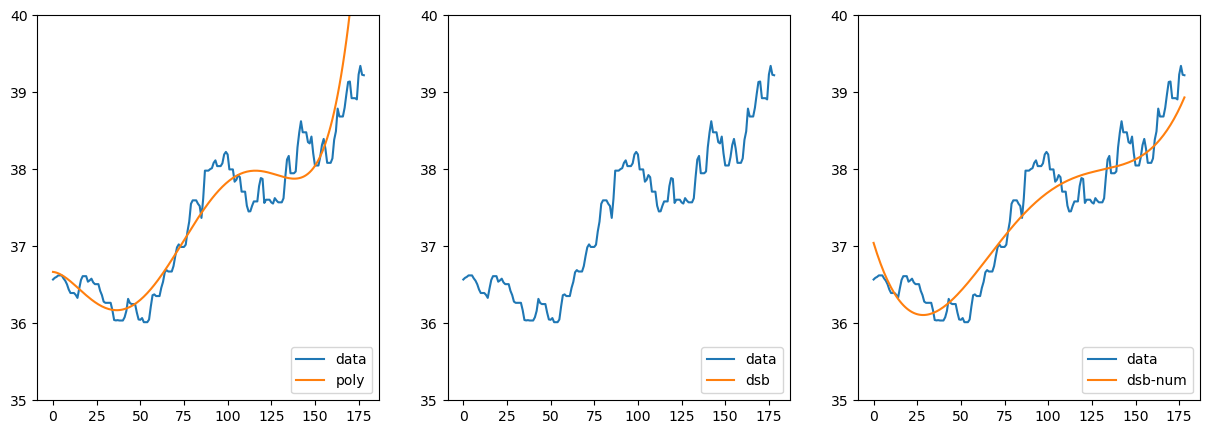

            median   variance  std. div.    lin. div.  covariance  concordance
poly     37.560950   1.367871   1.169560    55.644263    0.979259     0.885912
dsb      72.753695  57.351572   7.573082  5548.144398   -5.639062    -0.008702
dsb-num  37.488555   0.670088   0.818589    45.669096    0.712485     0.937804
data     37.569800   0.842787   0.918034     0.000000    0.842787     1.000000


In [19]:
# Read extra data
raw_data_extra = pd.read_excel("data/usd_2023-2024_2.xlsx", "USD")
usd_data_extra = np.array(raw_data_extra.iloc[0:179, 6].values)
extra = usd_data_extra.size


# Fitting
fitted_poly = timed(lambda: poly_fit(usd_data, 6, length=extra), label="poly")
fitted_dsb = timed(
    lambda: dsb_fit(
        "a0 + a1*t + a2*sin(a3*t) + a4*cos(a5*t)",
        "t",
        usd_data,
        numeric=False,
        length=extra,
    ),
    label="dsb",
)
fitted_dsb_numeric = timed(
    lambda: dsb_fit(
        "a0 + a1*t + a2*sin(a3*t) + a4*cos(a5*t)", "t", usd_data, length=extra
    ),
    label="dsb_num",
)

# Display
results = (fitted_poly, "poly"), (fitted_dsb, "dsb"), (fitted_dsb_numeric, "dsb-num")
multi_plot(usd_data_extra, *results, ylims=(35, 40))
statistics(usd_data_extra, *results)

## Трансцендентальна модель
Це ще одна із ідеальних моделей, тому необхідно її імпортувати. Використовує тригонометрію, тому вона повинна бути більш складною для БДС.

Параметри моделі:
- form: $0.2*sin(0.005*t) + 2.12*cos(0.005*t)$
- size: 10000
- sigma: 1

[poly] took 7.27090ms to complete.
[dsb] took 110.44890ms to complete.
[dsb_num] took 94.19130ms to complete.


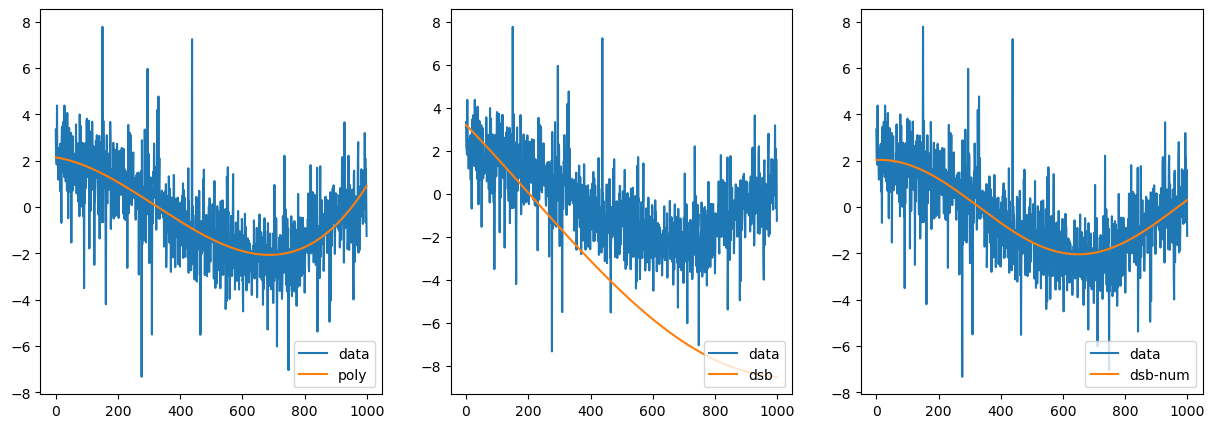

           median   variance  std. div.    lin. div.  covariance  concordance
poly    -0.680314   1.874303   1.369052   953.423262    1.874303     0.682307
dsb     -4.544439  13.398902   3.660451  3753.819583    4.090989     0.246375
dsb-num -0.681660   1.891236   1.375222   947.441534    1.884252     0.683766
data    -0.517366   3.593164   1.895564     0.000000    3.593164     1.000000


In [20]:
# Import model
from modules.models import transcendental1

ideal = transcendental1()
model = apply_noise(ideal, sigma=1)

# Fitting
fitted_poly = timed(lambda: poly_fit(model, 4), label="poly")
fitted_dsb = timed(
    lambda: dsb_fit("a0*sin(a2*t) + a3*cos(a2*t)", "t", model, numeric=False), label="dsb"
)
fitted_dsb_numeric = timed(
    lambda: dsb_fit("a0*sin(a2*t) + a3*cos(a2*t)", "t", model), label="dsb_num"
)

# Display
results = (fitted_poly, "poly"), (fitted_dsb, "dsb"), (fitted_dsb_numeric, "dsb-num")
multi_plot(model, *results)
statistics(ideal, *results)

Начебто тут все добре, давайте спробуємо іншу модель, яка буде включати більше періодів функції.
- форма: $21.5*sin(0.02*t) - 12.3*cos(0.02*t)$
- розмір: 100

[poly] took 11.35860ms to complete.
[dsb] took 99.11720ms to complete.
[dsb_num] took 77.52910ms to complete.


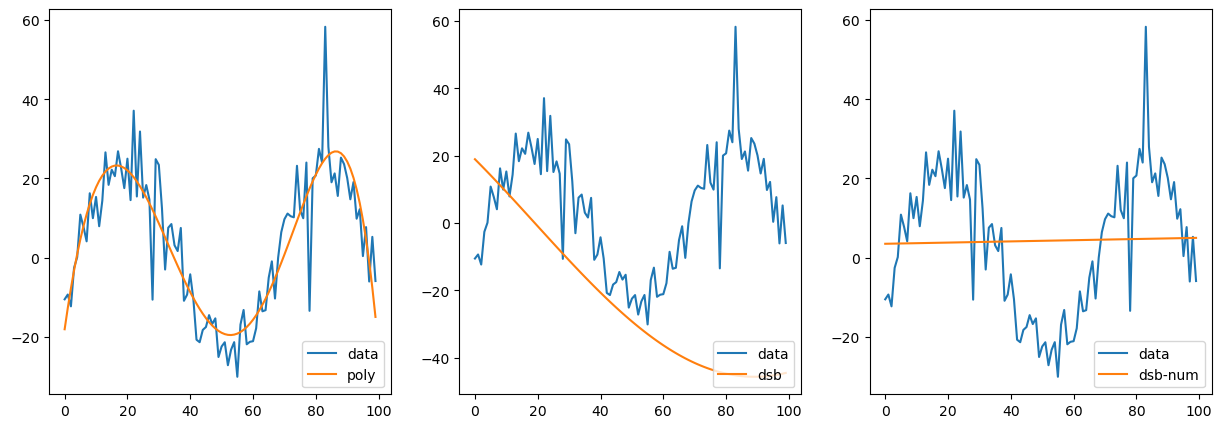

            median    variance  std. div.    lin. div.  covariance  concordance
poly      5.048344  241.995423  15.556202   575.693517  241.995423     0.872264
dsb     -28.811636  433.409629  20.818492  3015.392586   31.652749     0.030502
dsb-num   4.243161    0.189097   0.434853  1498.285158    0.189238     0.001190
data      7.745867  305.595031  17.481277     0.000000  305.595031     1.000000


In [21]:
from modules.models import transcendental2

ideal = transcendental2()
model = apply_noise(ideal)

# Fitting
fitted_poly = timed(lambda: poly_fit(model, 6), label="poly")
fitted_dsb = timed(
    lambda: dsb_fit("a0*sin(a2*t) + a3*cos(a2*t)", "t", model, numeric=False), label="dsb"
)
fitted_dsb_numeric = timed(
    lambda: dsb_fit("a0*sin(a2*t) + a3*cos(a2*t)", "t", model, maxfev=1000), label="dsb_num"
)

# Display
results = (fitted_poly, "poly"), (fitted_dsb, "dsb"), (fitted_dsb_numeric, "dsb-num")
multi_plot(model, *results)
statistics(ideal, *results)

Хм, потрібно конфігурувати maxfev щоб запобігати перенавчанню, інакше графік приймає вигляд прямої лінії. В іншому виглядає нормально, якщо набір даних включає в собі не більше двох інтервалів функції. Я пробував включити більше, але тоді чисельна частина не справляється і генерує ту же пряму лінію, тому потрібно бути уважніше.

### Штуки 5го порядку
Давайте спробуємо більш високий порядок знову, незважаючи на те, що це не дуже спрацювало раніше.
- форма: $-7.22*cos(0.015*t) - 0.54*sin(0.015*t) + 1.9*cos(0.015*t)$
- розмір: 500

> Мда, воно і тут не захотіло працювати

In [22]:
# from modules.models import transcendental3

# ideal = transcendental3()
# model = apply_noise(ideal)

# # Fitting
# fitted_poly = timed(lambda: poly_fit(model, 6), label="poly")
# fitted_dsb = timed(
#     lambda: dsb_fit("a0*cos(a1*t) + a2*sin(a1*t) + a3*cos(a1*t)", "t", model, numeric=False, rank=5), label="dsb"
# )
# fitted_dsb_numeric = timed(
#     lambda: dsb_fit("a0*cos(a1*t) + a2*sin(a1*t) + a3*cos(a1*t)", "t", model, maxfev=1000, rank=5), label="dsb_num"
# )

# # Display
# results = (fitted_poly, "poly"), (fitted_dsb, "dsb"), (fitted_dsb_numeric, "dsb-num")
# multi_plot(model, *results)
# statistics(ideal, *results)

Тут причина для відмови в тому що просто нема розв'язків для внутрішньої системи рівнянь незважаючи на те, що цього разу частини всіх порядків присутні. Я спробував різні порядки для того щоб можливо знайти рішення (4й, 5й та 6й, що є найбільшим можливим), але нічого не зміг знайти.

Тут очевидно присутня закономірність між загальним виглядом функції та тим, коли вона не піддається БДС. Я бачу лише те, що кожного разу непарна кількість тригонометричних функцій дає такий ефект, але спроба тут додати ще один елемент зі змінною не зробило систему вирішуваною.

В тих випадках же де БДС працює, то він стабільно показує краще показники ніж інші альтернативи, і тут я маю на увазі його чисельну версію. БДС сам по собі в жодному з разів не видав адекватних результатів і підходить лише як міст між поліномом та нелінійною моделлю, хоча і потребує подальшого навчання. В будь якому випадку цією функцією користуватися достатньо зручно, тому вже краще ніж голі чисельні методи.